In [31]:
import time
import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import optax

In [32]:
class Func(eqx.Module):
    scale: jnp.ndarray
    mlp: eqx.nn.MLP
    def __call__(self, t, y,args):
        return self.scale*self.mlp(y)

In [38]:
class LatentODE(eqx.Module):
    func: Func
    rnn_cell: eqx.nn.GRUCell
        
    hidden_to_latent: eqx.nn.Linear
    latent_to_hidden: eqx.nn.MLP
    hidden_to_data: eqx.nn.Linear
    
    hidden_size: int
    latent_size: int
    
    def __init__(self, *, data_size, hidden_size, latent_size, width_size, depth, key, **kwargs):
        super().__init__(**kwargs)
        mkey, gkey, hlkey,lhkey, hdkey=jrandom.split(key,5)
        
        scale = jnp.ones(())
        mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size,
            width_size = width_size,
            depth=depth,
            activation=jnn.softplus,
            final_activation=jnn.tanh,
            key=mkey)
        self.func = Func(scale, mlp)
        self.rnn_cell = eqx.nn.GRUCell(data_size+1,hidden_size,key=gkey)
        self.hidden_to_latent = eqx.nn.Linear(hidden_size, 2*latent_size, key=hlkey)
        self.latent_to_hidden = eqx.nn.MLP(
            latent_size, hidden_size, width_size=width_size, depth=depth,key=lhkey)
        self.hidden_to_data = eqx.nn.Linear(hidden_size, data_size, key=hdkey)
        
        self.hidden_size = hidden_size
        self.latent_size = latent_size
    # Encoder of the VAE
    def _latent(self,ts,ys,key):
        print(ys.shape)
        data = jnp.concatenate([ts[:,None],ys],axis=1)
        hidden = jnp.zeros((self.hidden_size,))
        for data_i in reversed(data):
            hidden=self.rnn_cell(data_i,hidden)
        context = self.hidden_to_latent(hidden)
        mean, logstd = context[: self.latent_size], context[self.latent_size:]
        std = jnp.exp(logstd)
        latent = mean + jrandom.normal(key,(self.latent_size,))+std
        return latent, mean, std
    
    # Decoder of the VAE
    def _sample(self, ts, latent):
        dt0 = 0.4
        y0 = self.latent_to_hidden(latent)
        sol = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
        diffrax.Tsit5(),
        ts[0],
        ts[-1],
        dt0,
        y0,
        saveat = diffrax.SaveAt(ts=ts),
        )
        return jax.vmap(self.hidden_to_data)(sol.ys)
    
    @staticmethod
    def _loss(ys, pred_ys,mean, std):
        #-log p_theta with Gaussian p_theta
        reconstruction_loss = 0.5 * jnp.sum((ys-pred_ys)**2)
        #KL(N(mean, std^2)||N(0,1))
        variational_loss = 0.5 * jnp.sum(mean**2+std**2-2*jnp.log(std)-1)
        return reconstruction_loss+variational_loss
    
    #run both encoder and decoder during training
    def train(self, ts, ys, *, key):
        latent, mean, std = self._latent(ts, ys, key)
        pred_ys = self._sample(ts, latent)
        print(self.hidden_size)
        print(self.latent_size)
        return self._loss(ys, pred_ys, mean, std)
    
    def sample(self, ts, *, key):
        latent = jrandom.normal(key, (self.latent_size,))
        return self._sample(ts, latent)

In [39]:
def get_data(dataset_size, *, key):
    ykey,tkey1,tkey2 = jrandom.split(key,3)
    y0 = jrandom.normal(ykey,(dataset_size,2))
    
    t0 = 0
    t1 = 2 + jrandom.uniform(tkey1, (dataset_size,))
    ts = jrandom.uniform(tkey2, (dataset_size, 20))*(t1[:,None]-t0)+t0
    ts = jnp.sort(ts)
    dt0 = 0.1
    
    def func(t,y,args):
        return jnp.array([[-0.1,1.3],[-1,-0.1]])@y
    def solve(ts,y0):
        sol = diffrax.diffeqsolve(
            diffrax.ODETerm(func),
            diffrax.Tsit5(),
            ts[0],
            ts[-1],
            dt0,
            y0,
            saveat=diffrax.SaveAt(ts=ts))
        return sol.ys
    ys = jax.vmap(solve)(ts,y0)
    return ts, ys

In [40]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key,1)
        start = 0
        end = batch_size
        while start < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [41]:
def main(
    dataset_size=10000,
    batch_size=256,
    lr=1e-2,
    steps=250,
    save_every=50,
    hidden_size=16,
    latent_size=16,
    width_size=16,
    depth=2,
    seed=5678):
    key=jrandom.PRNGKey(seed)
    data_key, model_key, loader_key, train_key, sample_key = jrandom.split(key,5)
    
    ts, ys = get_data(dataset_size, key=data_key)
    
    model = LatentODE(
        data_size = ys.shape[-1],
        hidden_size = hidden_size,
        latent_size = latent_size,
        width_size = width_size,
        depth = depth,
        key=model_key
    )
    
    @eqx.filter_value_and_grad
    def loss(model, ts_i, ys_i, key_i):
        batch_size, _ = ts_i.shape
        key_i = jrandom.split(key_i, batch_size)
        loss = jax.vmap(model.train)(ts_i, ys_i, key=key_i)
        return jnp.mean(loss)
    
    @eqx.filter_jit
    def make_step(model, opt_state, ts_i, ys_i, key_i):
        value, grads = loss(model,ts_i,ys_i,key_i)
        key_i = jrandom.split(key_i,1)[0]
        updates, opt_state = optim.update(grads, opt_state)
        model=eqx.apply_updates(model,updates)
        return value, model, opt_state, key_i
    optim=optax.adam(lr)
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
    
    # plot results
    num_plots = 1 + (steps-1)//save_every
    if ((steps-1) % save_every) != 0:
        num_plots += 1
    fig, axs = plt.subplots(1, num_plots, figsize=(num_plots*8,8))
    axs[0].set_ylabel("x")
    axs = iter(axs)
    for step, (ts_i, ys_i) in zip(
        range(steps), dataloader((ts, ys), batch_size, key=loader_key)
    ):
        start = time.time()
        value, model, opt_state, train_key = make_step(
            model, opt_state, ts_i, ys_i, train_key
        )
        end = time.time()
        print(f"Step: {step}, Loss: {value}, Computation time: {end-start}")
        

(20, 2)
16
16
Step: 0, Loss: 19.482112884521484, Computation time: 30.831073999404907
Step: 1, Loss: 17.960769653320312, Computation time: 0.21074295043945312
Step: 2, Loss: 16.635345458984375, Computation time: 0.19555902481079102
Step: 3, Loss: 17.64173126220703, Computation time: 0.2215440273284912
Step: 4, Loss: 15.866716384887695, Computation time: 0.22096920013427734
Step: 5, Loss: 15.14842414855957, Computation time: 0.21159720420837402
Step: 6, Loss: 16.314502716064453, Computation time: 0.20553207397460938
Step: 7, Loss: 16.91912841796875, Computation time: 0.2049100399017334
Step: 8, Loss: 15.079574584960938, Computation time: 0.24156713485717773
Step: 9, Loss: 16.18557357788086, Computation time: 0.21551895141601562
Step: 10, Loss: 16.1568660736084, Computation time: 0.23908090591430664
Step: 11, Loss: 16.7288818359375, Computation time: 0.21463394165039062
Step: 12, Loss: 14.11604118347168, Computation time: 0.203779935836792
Step: 13, Loss: 13.984370231628418, Computation 

Step: 112, Loss: 6.169217109680176, Computation time: 0.30501699447631836
Step: 113, Loss: 6.406663417816162, Computation time: 0.28444576263427734
Step: 114, Loss: 6.378798484802246, Computation time: 0.2903621196746826
Step: 115, Loss: 6.351482391357422, Computation time: 0.31445908546447754
Step: 116, Loss: 6.595810890197754, Computation time: 0.29839491844177246
Step: 117, Loss: 6.161502838134766, Computation time: 0.2770218849182129
Step: 118, Loss: 6.804346561431885, Computation time: 0.3129448890686035
Step: 119, Loss: 7.225455284118652, Computation time: 0.020895957946777344
Step: 120, Loss: 6.257194519042969, Computation time: 0.3013949394226074
Step: 121, Loss: 7.068605422973633, Computation time: 0.28760290145874023
Step: 122, Loss: 6.232015132904053, Computation time: 0.2793281078338623
Step: 123, Loss: 6.145999431610107, Computation time: 0.2897300720214844
Step: 124, Loss: 5.845921516418457, Computation time: 0.28724217414855957
Step: 125, Loss: 6.306858062744141, Computa

Step: 225, Loss: 5.872195243835449, Computation time: 0.19579219818115234
Step: 226, Loss: 6.237074375152588, Computation time: 0.19539308547973633
Step: 227, Loss: 6.00838565826416, Computation time: 0.19423294067382812
Step: 228, Loss: 5.898082256317139, Computation time: 0.19440197944641113
Step: 229, Loss: 6.299516201019287, Computation time: 0.20044398307800293
Step: 230, Loss: 5.771559715270996, Computation time: 0.19233369827270508
Step: 231, Loss: 6.503746509552002, Computation time: 0.20082616806030273
Step: 232, Loss: 6.475078105926514, Computation time: 0.2140789031982422
Step: 233, Loss: 6.124886989593506, Computation time: 0.19525694847106934
Step: 234, Loss: 5.548612594604492, Computation time: 0.2600209712982178
Step: 235, Loss: 6.255526542663574, Computation time: 0.2736990451812744
Step: 236, Loss: 5.459768295288086, Computation time: 0.22895479202270508
Step: 237, Loss: 6.938872337341309, Computation time: 0.20845794677734375
Step: 238, Loss: 6.075936794281006, Comput

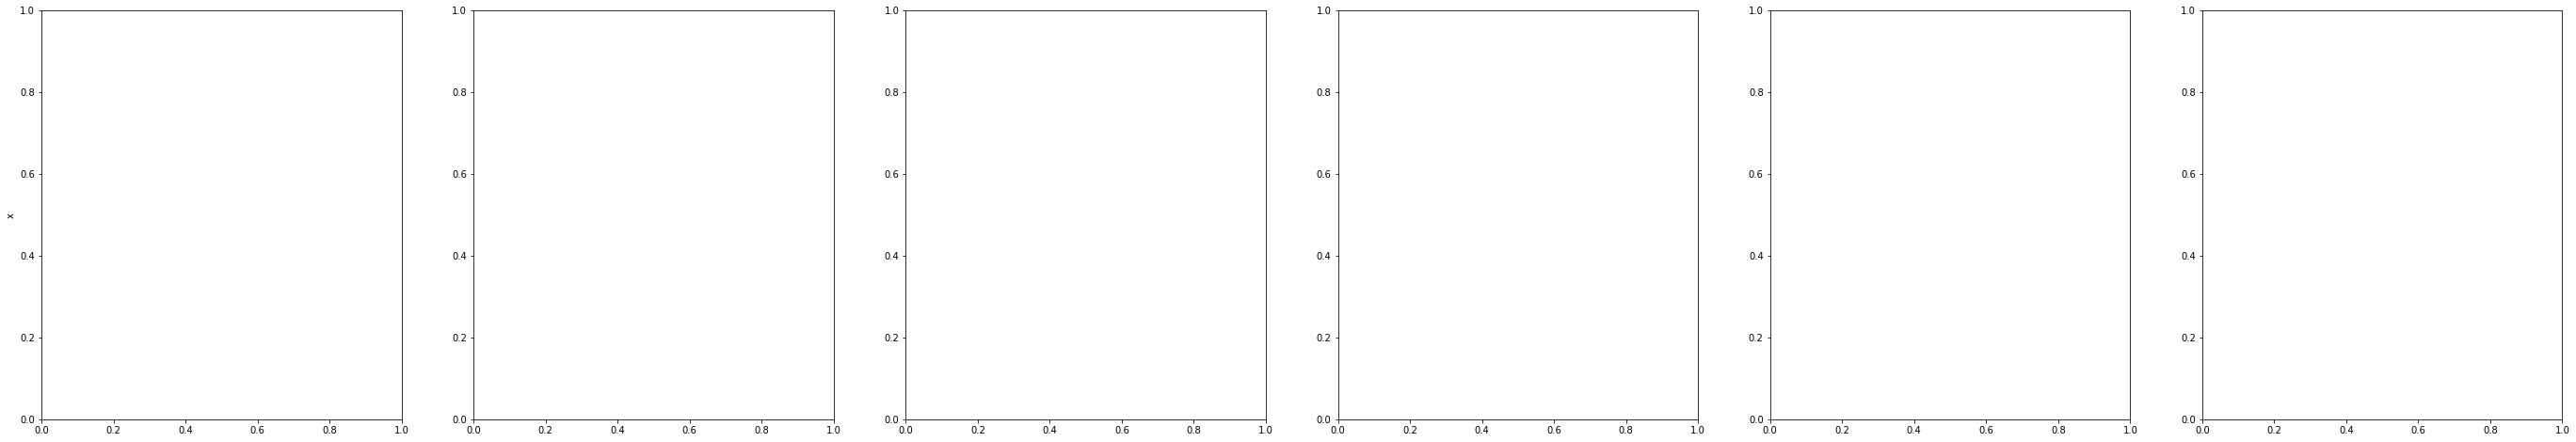

In [42]:
main()